In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
len(X)

1712

In [4]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=123)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [6]:
from keras import models, layers
from keras import Input
from keras.applications import ResNet50
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,2048)))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(512, activation='relu'))
additional_model.add(layers.Dense(4, activation='softmax'))


additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
Total params: 26,212,740
Trainable params: 26,159,620
Non-trainable params: 53,120
_________________________________________________________________


In [8]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [9]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='ResNet_average_pooling.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [10]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [11]:
class_weight = {0: 1.1,
                1: 1.1,
                2: 1,
                3: 1}

In [12]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=200, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/200
43/42 [==============================] - 32s 747ms/step - loss: 1.4382 - acc: 0.3163 - auc: 0.5673 - precision: 0.4012 - recall: 0.0258 - f1score: 0.1044 - val_loss: 2.4722 - val_acc: 0.2857 - val_auc: 0.5770 - val_precision: 0.3841 - val_recall: 0.0491 - val_f1score: 0.0946
Epoch 2/200
43/42 [==============================] - 14s 334ms/step - loss: 1.3997 - acc: 0.3324 - auc: 0.5815 - precision: 0.3591 - recall: 0.0491 - f1score: 0.1067 - val_loss: 1.4383 - val_acc: 0.2332 - val_auc: 0.5855 - val_precision: 0.3642 - val_recall: 0.0390 - val_f1score: 0.0987
Epoch 3/200
43/42 [==============================] - 15s 345ms/step - loss: 1.3909 - acc: 0.3492 - auc: 0.5902 - precision: 0.3668 - recall: 0.0340 - f1score: 0.1085 - val_loss: 1.4527 - val_acc: 0.2478 - val_auc: 0.5942 - val_precision: 0.3840 - val_recall: 0.0324 - val_f1score: 0.0987
Epoch 4/200
43/42 [==============================] - 14s 334ms/step - loss: 1.3765 - acc: 0.3879 - auc: 0.5972 - precision: 0.4048 - rec

43/42 [==============================] - 14s 336ms/step - loss: 1.1620 - acc: 0.4660 - auc: 0.6994 - precision: 0.5379 - recall: 0.1286 - f1score: 0.1313 - val_loss: 1.2302 - val_acc: 0.3907 - val_auc: 0.7005 - val_precision: 0.5377 - val_recall: 0.1301 - val_f1score: 0.1238
Epoch 30/200
43/42 [==============================] - 14s 336ms/step - loss: 1.1558 - acc: 0.4646 - auc: 0.7017 - precision: 0.5372 - recall: 0.1318 - f1score: 0.1322 - val_loss: 1.1830 - val_acc: 0.3994 - val_auc: 0.7028 - val_precision: 0.5372 - val_recall: 0.1334 - val_f1score: 0.1264
Epoch 31/200
43/42 [==============================] - 14s 335ms/step - loss: 1.1772 - acc: 0.4522 - auc: 0.7037 - precision: 0.5378 - recall: 0.1346 - f1score: 0.1307 - val_loss: 1.2103 - val_acc: 0.4227 - val_auc: 0.7047 - val_precision: 0.5378 - val_recall: 0.1359 - val_f1score: 0.1247
Epoch 32/200
43/42 [==============================] - 14s 335ms/step - loss: 1.1432 - acc: 0.4697 - auc: 0.7058 - precision: 0.5390 - recall: 0.13

43/42 [==============================] - 14s 334ms/step - loss: 1.1055 - acc: 0.4967 - auc: 0.7379 - precision: 0.5440 - recall: 0.1968 - f1score: 0.1377 - val_loss: 1.3377 - val_acc: 0.3703 - val_auc: 0.7383 - val_precision: 0.5440 - val_recall: 0.1976 - val_f1score: 0.1227
Epoch 58/200
43/42 [==============================] - 14s 335ms/step - loss: 1.0651 - acc: 0.5332 - auc: 0.7388 - precision: 0.5443 - recall: 0.1988 - f1score: 0.1411 - val_loss: 1.2974 - val_acc: 0.4140 - val_auc: 0.7392 - val_precision: 0.5442 - val_recall: 0.1999 - val_f1score: 0.1259
Epoch 59/200
43/42 [==============================] - 14s 335ms/step - loss: 1.0818 - acc: 0.4989 - auc: 0.7396 - precision: 0.5439 - recall: 0.2008 - f1score: 0.1397 - val_loss: 1.1439 - val_acc: 0.4956 - val_auc: 0.7401 - val_precision: 0.5442 - val_recall: 0.2019 - val_f1score: 0.1335
Epoch 60/200
43/42 [==============================] - 14s 335ms/step - loss: 1.0691 - acc: 0.5047 - auc: 0.7407 - precision: 0.5445 - recall: 0.20

43/42 [==============================] - 14s 335ms/step - loss: 1.0756 - acc: 0.5106 - auc: 0.7587 - precision: 0.5568 - recall: 0.2435 - f1score: 0.1407 - val_loss: 1.1780 - val_acc: 0.4198 - val_auc: 0.7589 - val_precision: 0.5567 - val_recall: 0.2439 - val_f1score: 0.1311
Epoch 86/200
43/42 [==============================] - 14s 335ms/step - loss: 1.0334 - acc: 0.5179 - auc: 0.7592 - precision: 0.5568 - recall: 0.2446 - f1score: 0.1440 - val_loss: 1.1124 - val_acc: 0.4723 - val_auc: 0.7595 - val_precision: 0.5570 - val_recall: 0.2453 - val_f1score: 0.1381
Epoch 87/200
43/42 [==============================] - 14s 335ms/step - loss: 1.0281 - acc: 0.5522 - auc: 0.7599 - precision: 0.5575 - recall: 0.2461 - f1score: 0.1455 - val_loss: 1.1606 - val_acc: 0.4519 - val_auc: 0.7602 - val_precision: 0.5578 - val_recall: 0.2469 - val_f1score: 0.1342
Epoch 88/200
43/42 [==============================] - 14s 335ms/step - loss: 1.0215 - acc: 0.5310 - auc: 0.7605 - precision: 0.5579 - recall: 0.24

43/42 [==============================] - 14s 335ms/step - loss: 0.9775 - acc: 0.5588 - auc: 0.7715 - precision: 0.5638 - recall: 0.2772 - f1score: 0.1494 - val_loss: 1.1652 - val_acc: 0.4431 - val_auc: 0.7718 - val_precision: 0.5640 - val_recall: 0.2778 - val_f1score: 0.1353
Epoch 114/200
43/42 [==============================] - 14s 335ms/step - loss: 0.9988 - acc: 0.5610 - auc: 0.7720 - precision: 0.5642 - recall: 0.2784 - f1score: 0.1487 - val_loss: 1.1108 - val_acc: 0.4694 - val_auc: 0.7723 - val_precision: 0.5644 - val_recall: 0.2790 - val_f1score: 0.1395
Epoch 115/200
43/42 [==============================] - 14s 335ms/step - loss: 1.0101 - acc: 0.5281 - auc: 0.7725 - precision: 0.5646 - recall: 0.2795 - f1score: 0.1473 - val_loss: 1.2612 - val_acc: 0.4111 - val_auc: 0.7726 - val_precision: 0.5645 - val_recall: 0.2799 - val_f1score: 0.1307
Epoch 116/200
43/42 [==============================] - 14s 335ms/step - loss: 0.9900 - acc: 0.5354 - auc: 0.7729 - precision: 0.5647 - recall: 0

43/42 [==============================] - 14s 335ms/step - loss: 0.9592 - acc: 0.5866 - auc: 0.7824 - precision: 0.5727 - recall: 0.3052 - f1score: 0.1517 - val_loss: 1.0734 - val_acc: 0.4869 - val_auc: 0.7826 - val_precision: 0.5730 - val_recall: 0.3058 - val_f1score: 0.1428
Epoch 142/200
43/42 [==============================] - 14s 335ms/step - loss: 0.9743 - acc: 0.5515 - auc: 0.7828 - precision: 0.5731 - recall: 0.3062 - f1score: 0.1506 - val_loss: 1.2716 - val_acc: 0.4636 - val_auc: 0.7829 - val_precision: 0.5731 - val_recall: 0.3066 - val_f1score: 0.1330
Epoch 143/200
43/42 [==============================] - 14s 335ms/step - loss: 0.9622 - acc: 0.5785 - auc: 0.7831 - precision: 0.5733 - recall: 0.3071 - f1score: 0.1520 - val_loss: 1.4928 - val_acc: 0.4140 - val_auc: 0.7832 - val_precision: 0.5735 - val_recall: 0.3076 - val_f1score: 0.1253
Epoch 144/200
43/42 [==============================] - 14s 335ms/step - loss: 0.9697 - acc: 0.5793 - auc: 0.7833 - precision: 0.5736 - recall: 0

43/42 [==============================] - 14s 335ms/step - loss: 0.9381 - acc: 0.5858 - auc: 0.7906 - precision: 0.5809 - recall: 0.3277 - f1score: 0.1546 - val_loss: 1.1140 - val_acc: 0.4606 - val_auc: 0.7908 - val_precision: 0.5811 - val_recall: 0.3281 - val_f1score: 0.1407
Epoch 170/200
43/42 [==============================] - 14s 336ms/step - loss: 0.9304 - acc: 0.5822 - auc: 0.7910 - precision: 0.5812 - recall: 0.3285 - f1score: 0.1546 - val_loss: 1.4287 - val_acc: 0.3848 - val_auc: 0.7910 - val_precision: 0.5812 - val_recall: 0.3288 - val_f1score: 0.1249
Epoch 171/200
43/42 [==============================] - 14s 335ms/step - loss: 0.9161 - acc: 0.5844 - auc: 0.7912 - precision: 0.5813 - recall: 0.3292 - f1score: 0.1558 - val_loss: 1.1642 - val_acc: 0.4898 - val_auc: 0.7913 - val_precision: 0.5815 - val_recall: 0.3296 - val_f1score: 0.1391
Epoch 172/200
43/42 [==============================] - 14s 335ms/step - loss: 0.9356 - acc: 0.5676 - auc: 0.7915 - precision: 0.5816 - recall: 0

43/42 [==============================] - 14s 335ms/step - loss: 0.8833 - acc: 0.6129 - auc: 0.7978 - precision: 0.5881 - recall: 0.3475 - f1score: 0.1596 - val_loss: 1.2712 - val_acc: 0.4636 - val_auc: 0.7979 - val_precision: 0.5882 - val_recall: 0.3478 - val_f1score: 0.1353
Epoch 198/200
43/42 [==============================] - 14s 335ms/step - loss: 0.8912 - acc: 0.5953 - auc: 0.7980 - precision: 0.5882 - recall: 0.3482 - f1score: 0.1580 - val_loss: 1.1537 - val_acc: 0.4781 - val_auc: 0.7982 - val_precision: 0.5884 - val_recall: 0.3485 - val_f1score: 0.1426
Epoch 199/200
43/42 [==============================] - 14s 335ms/step - loss: 0.8954 - acc: 0.6019 - auc: 0.7983 - precision: 0.5885 - recall: 0.3489 - f1score: 0.1590 - val_loss: 1.1754 - val_acc: 0.4636 - val_auc: 0.7984 - val_precision: 0.5886 - val_recall: 0.3492 - val_f1score: 0.1388
Epoch 200/200
43/42 [==============================] - 14s 336ms/step - loss: 0.8998 - acc: 0.6004 - auc: 0.7986 - precision: 0.5888 - recall: 0

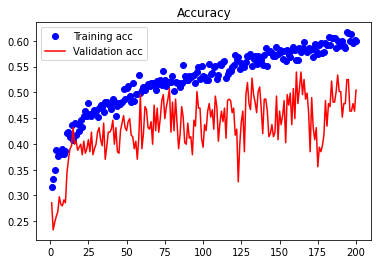

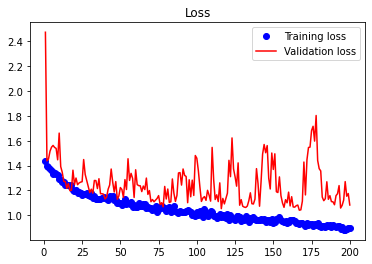

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [14]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 1s 3ms/step
loss: 1.083, accuracy: 0.504, auc: 0.799, precision: 0.589, recall: 0.350, f1score: 0.145


In [16]:
from keras.models import Model, load_model

new_model = models.load_model('ResNet_average_pooling.hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [17]:
_loss, _acc, _auc, _precision, _recall, _f1score = new_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 3s 7ms/step
loss: 1.041, accuracy: 0.487, auc: 0.791, precision: 0.525, recall: 0.403, f1score: 0.144
